In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def roundTime(dt=None):    
    dt = dt.to_pydatetime()
    roundTo = 15*60    
    if dt == None : dt = datetime.datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

def create_start_timestamp(row):
    return row['Start Date'] + " " + row['Start Time']

def create_end_timestamp(row):
    return row['End Date'] + " " + row['End Time']


def conv_entries(arr):  
    int_arr = [int(x) for x in arr]
    if int_arr[2] > 29:
        int_arr[1] += 1        
    int_arr[2] = 0
    mins = int_arr[0]*60 + int_arr[1]
    rem = mins % 15
    if rem > 7:
        mins += (15-rem)
    else:
        mins -= rem        
    return mins

def calc_quarter_load(row):
    dur = row['Charging Time (hh:mm:ss)']
    total = row['Energy (kWh)']
    return (total/dur)*15.0

def calc_sessions_dur(row):
    return (row['Total kWh']/50.0)*60.0

def calc_minute_load(row):
    return row['Total kWh']/row['Session_Duration']


def add_to_backbone(row):
    iters = int(row['Session_Duration'])
    load_per_min = row['Minute_Load']
    for i in range(iters):
        backbone.loc[backbone['date_time'] == row['Start_Timestamp'] + datetime.timedelta(minutes=i), 'value'] += load_per_min  
        backbone.loc[backbone['date_time'] == row['Start_Timestamp'] + datetime.timedelta(minutes=i), 'sessions'] += 1    

In [3]:
dfpk = pd.read_csv (r'/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/PerthKinross_2016-2019.csv')

print(set(list(dfpk['Model'])))
rapid_chargers = ['APT Triple Rapid Charger', 'Siemens Triple Rapid Charger']
dfpk = dfpk[dfpk['Model'].isin(rapid_chargers) == True]



{'Siemens Semi-Rapid', 'APT 7kW Dual Outlet', 'APT 22kW Raption', 'APT 22kW Dual Outlet', 'APT Triple Rapid Charger', 'Siemens Triple Rapid Charger', 'Siemens 7 kW Dual Outlet'}


In [4]:
dfpk = dfpk[dfpk['Total kWh'].notna()]

dfpk['Start_Timestamp'] = dfpk.apply(lambda row: create_start_timestamp(row), axis=1)
dfpk['End_Timestamp'] = dfpk.apply(lambda row: create_end_timestamp(row), axis=1)

In [5]:
dfpk['Session_Duration'] = dfpk.apply(lambda row: calc_sessions_dur(row), axis=1)
dfpk['Session_Duration'] = round(dfpk['Session_Duration'])
dfpk = dfpk[dfpk['Session_Duration'] > 0.0]
dfpk['Minute_Load'] = dfpk.apply(lambda row: calc_minute_load(row), axis=1)

In [6]:
cutoff = datetime.datetime.strptime("2017-07-01 00:00", '%Y-%m-%d %H:%M')
dfpk['Start_Timestamp'] = dfpk['Start_Timestamp'].map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M'))
dfpk['End_Timestamp'] = dfpk['End_Timestamp'].map(lambda x: datetime.datetime.strptime(x, '%d/%m/%Y %H:%M'))
dfpk = dfpk[dfpk['Start_Timestamp'] >= cutoff]

In [7]:
start = dfpk['Start_Timestamp'].min()
start = cutoff
end = dfpk['End_Timestamp'].max()
backbone = pd.DataFrame({'date_time': pd.date_range(start, end, freq="1min")})
backbone.set_index('date_time')
backbone['value'] = 0.0
backbone['sessions'] = 0

In [8]:
from scipy import stats
dfpk['z_score'] = np.abs(stats.zscore(dfpk['Session_Duration']))
dfpk = dfpk[dfpk.z_score <= 3.0]

#list(dfpk)

In [9]:
dfpk.apply(lambda row: add_to_backbone(row), axis=1)

0        None
1        None
2        None
4        None
5        None
         ... 
55700    None
55701    None
55702    None
55705    None
55706    None
Length: 39682, dtype: object

In [10]:
backbone_quarter = pd.DataFrame({'date_time': pd.date_range(start, end, freq="15min")})
backbone_quarter['value'] = 0.0
backbone_quarter['sessions'] = 0
backbone_quarter = backbone_quarter[:-1]

quarter_loads = []
quarter_sessions = []
values = backbone['value']
sessions = backbone['sessions']
avg = 0.0
sss = 0
for i in range(len(values)):
    avg += values[i]
    sss += sessions[i]
    if (i+1)%15 == 0:
        quarter_loads.append(avg/15.0)
        quarter_sessions.append(sss)        
        avg = 0.0
        sss = 0
    
print(len(quarter_loads))
len(backbone)


76031


1140475

In [11]:
end

Timestamp('2019-08-31 23:54:00')

In [12]:
backbone_quarter['value'] = quarter_loads
backbone_quarter['sessions'] = quarter_sessions
max(backbone_quarter['sessions'])


backbone_daily = pd.DataFrame({'date_time': pd.date_range(start, end, freq="24h")})
backbone_daily.set_index('date_time')
backbone_daily['value'] = 0.0
backbone_daily['sessions'] = 0
backbone_daily = backbone_daily[:-1]

for row in backbone_daily.itertuples():
    avg_load = 0.0
    avg_sessions = 0
    start_time = backbone_daily.at[row.Index, 'date_time']
    for i in range(96):
        avg_load += backbone_quarter[backbone_quarter['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['value'].item()    
        avg_sessions += backbone_quarter[backbone_quarter['date_time'] == start_time + datetime.timedelta(minutes=15*i)]['sessions'].item()
    avg_load /= 96.0    
    backbone_daily.loc[row.Index, 'value'] = avg_load  
    backbone_daily.loc[row.Index, 'sessions'] = avg_sessions  


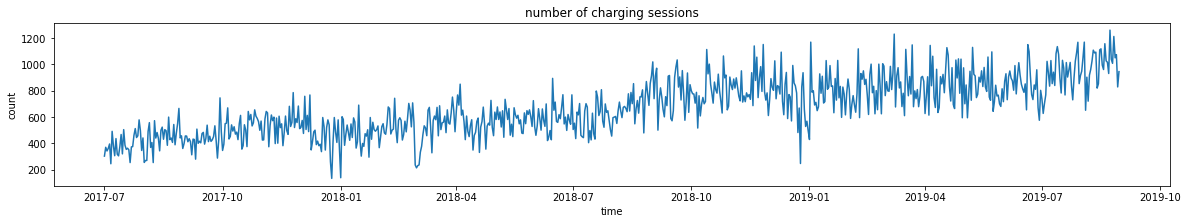

In [13]:
backbone_daily['sessions']

x_sessions = backbone_daily['date_time']
y_sessions = backbone_daily['sessions']
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(x_sessions, y_sessions)
plt.xlabel("time")
plt.ylabel("count")
plt.title("number of charging sessions")
plt.show()

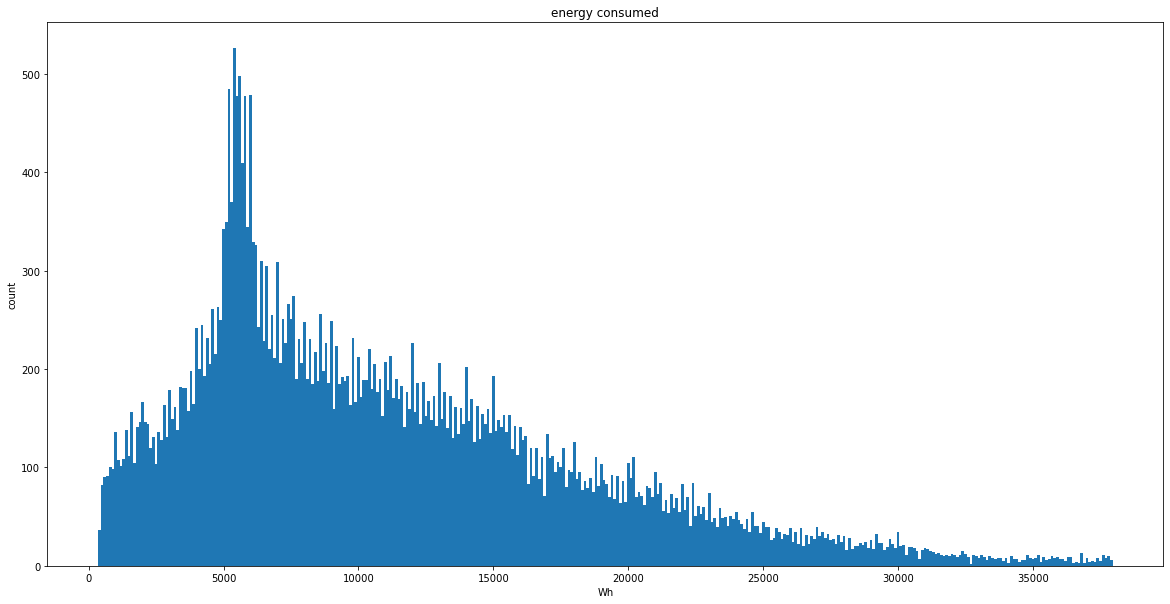

In [14]:
# len(backbone)
# list(dfpk)
# dfpk['Total kWh']

dfpk['WhDelivered'] = dfpk['Total kWh'].apply(lambda x: round(int(x*1000)/100)*100)
vc_energy = dfpk.WhDelivered.value_counts()
vc_energy = vc_energy.sort_index()

x_energy = vc_energy.index
y_energy = vc_energy.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_energy, y_energy, width=100)
plt.xlabel("Wh")
plt.ylabel("count")
plt.title("energy consumed")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_energy.png')
plt.show()

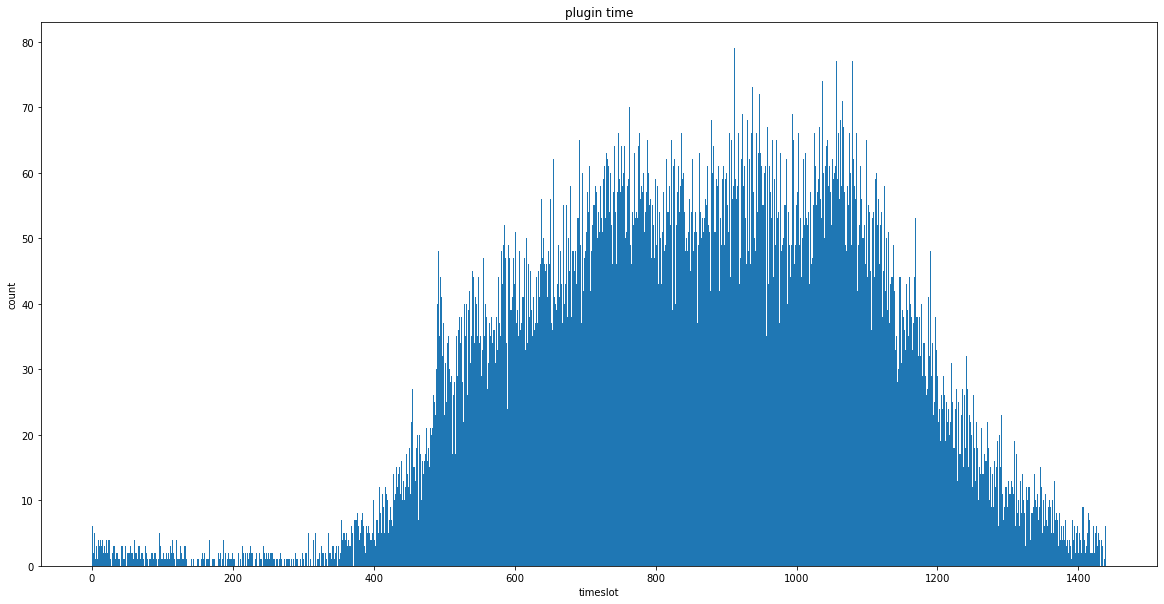

In [15]:


dfpk['Start Time']

vc_plugin = dfpk['Start Time'].value_counts()
vc_plugin = vc_plugin.sort_index()

x_plugin = []
for time in vc_plugin.index:
    minutes = int(time[:2])*60 + int(time[3:])
    x_plugin.append(minutes)
len(x_plugin)

#x_plugin = vc_plugin.index
#x_plugin = range(94)
y_plugin = vc_plugin.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_plugin, y_plugin, width=1)
plt.xlabel("timeslot")
plt.ylabel("count")
plt.title("plugin time")

plt.show()



In [16]:
list(dfpk)

['CP ID',
 'Connector',
 'Start Date',
 'Start Time',
 'End Date',
 'End Time',
 'Total kWh',
 'Site',
 'Model',
 'Start_Timestamp',
 'End_Timestamp',
 'Session_Duration',
 'Minute_Load',
 'z_score',
 'WhDelivered']

In [17]:
dfpk.Start_Timestamp

0       2019-08-31 23:26:00
1       2019-08-31 21:12:00
2       2019-08-31 20:26:00
4       2019-08-31 19:43:00
5       2019-08-31 19:20:00
                ...        
55700   2017-07-01 10:22:00
55701   2017-07-01 10:19:00
55702   2017-07-01 09:52:00
55705   2017-07-01 06:51:00
55706   2017-07-01 00:15:00
Name: Start_Timestamp, Length: 39682, dtype: datetime64[ns]

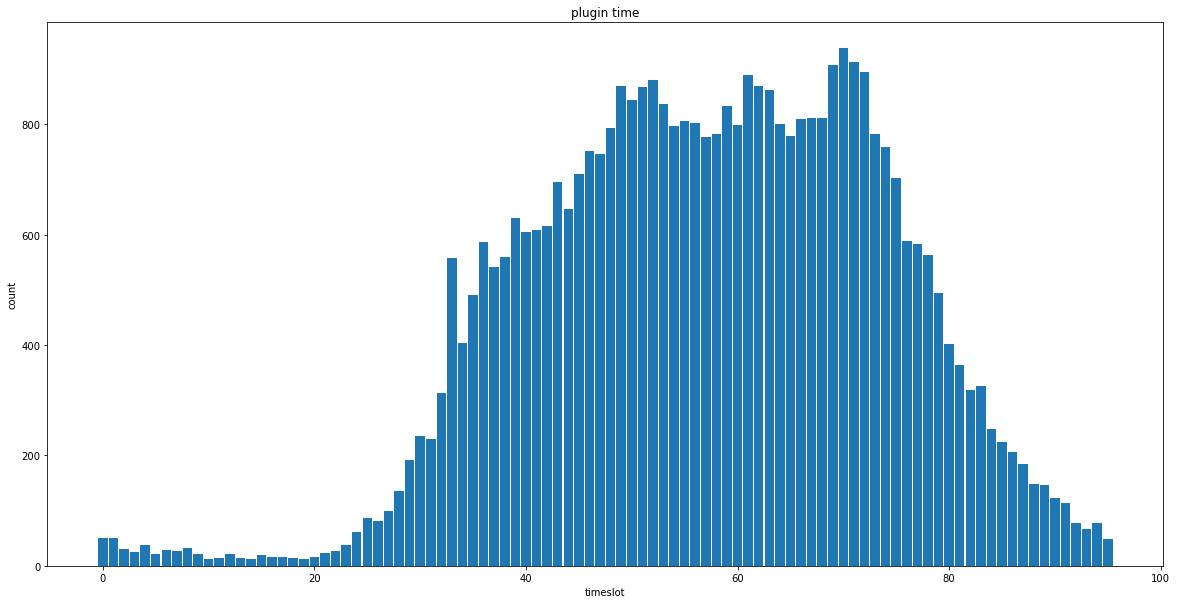

In [18]:
dfpk.Start_Timestamp = dfpk.Start_Timestamp.map(roundTime)

def get_hs_and_mins(ts):
    hours = str(ts.hour)
    minutes = str(ts.minute)
    if hours == '0':
        hours = '00'
    if minutes == '0':
        minutes = '00'        
    ts = datetime.datetime.strptime(hours + ":" + minutes, '%H:%M')    
    return ts

dfpk['plugin_time'] = dfpk.Start_Timestamp.map(get_hs_and_mins)
vc_plugin = dfpk.plugin_time.value_counts()
vc_plugin = vc_plugin.sort_index()

x_plugin = vc_plugin.index
x_plugin = range(96)
y_plugin = vc_plugin.values
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_plugin, y_plugin, width=0.9)
plt.xlabel("timeslot")
plt.ylabel("count")
plt.title("plugin time")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_plugin_time.png')
plt.show()


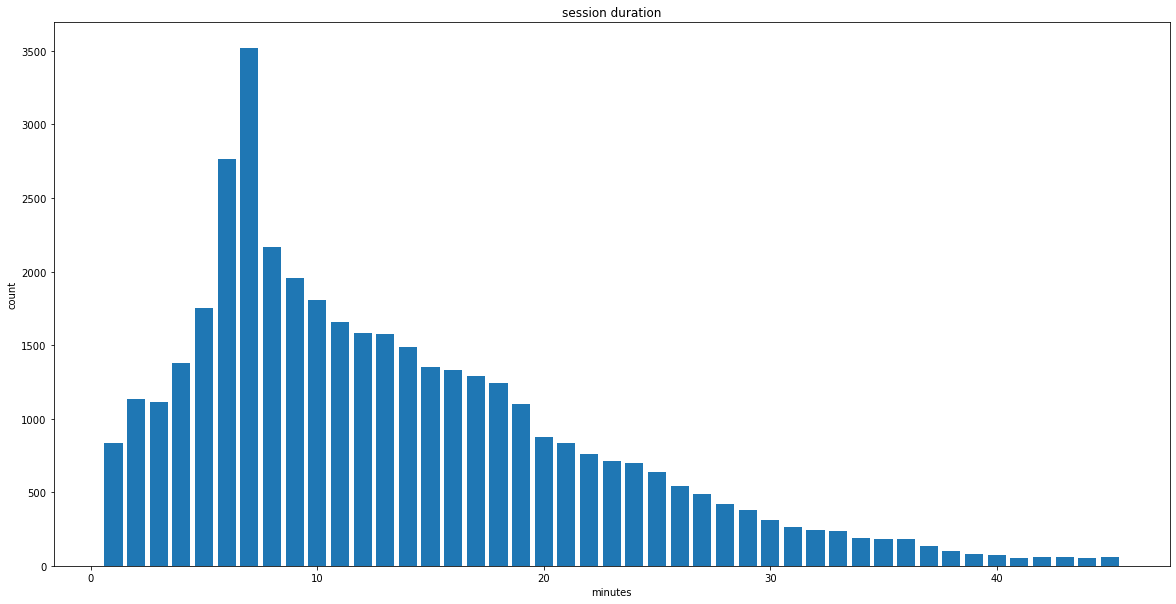

In [19]:
vc_duration = dfpk.Session_Duration.value_counts()
vc_duration = vc_duration.sort_index()
vc_duration = vc_duration[vc_duration.values > 1]
x_duration = vc_duration.index
y_duration = vc_duration.values

plt.rcParams["figure.figsize"] = (20,10)
plt.bar(x_duration, y_duration, width=0.8)

plt.xlabel("minutes")
plt.ylabel("count")
plt.title("session duration")
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_session_duration.png')
plt.show()

In [20]:
list(dfpk)

['CP ID',
 'Connector',
 'Start Date',
 'Start Time',
 'End Date',
 'End Time',
 'Total kWh',
 'Site',
 'Model',
 'Start_Timestamp',
 'End_Timestamp',
 'Session_Duration',
 'Minute_Load',
 'z_score',
 'WhDelivered',
 'plugin_time']

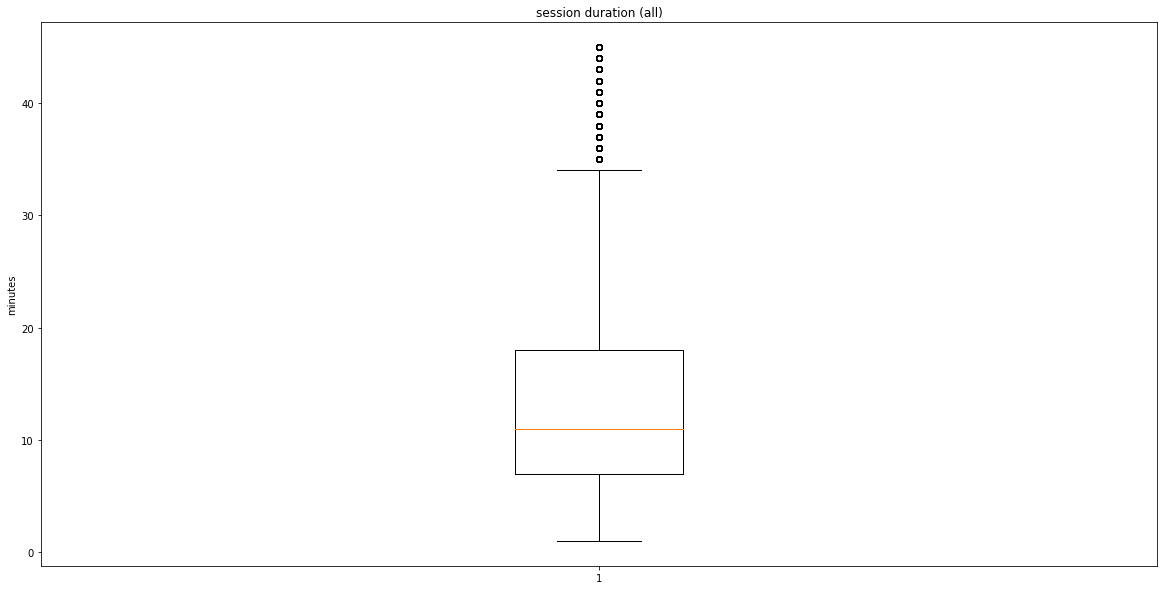

In [21]:

plt.boxplot(dfpk['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (all)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_box_all.png')
plt.show()

In [22]:
def get_weekend(ts):
    if ts.weekday() > 4:
        return 1
    return 0

dfpk['weekend'] = dfpk['Start_Timestamp'].apply(get_weekend)

df_weekday = dfpk[dfpk['weekend'] == 0]
df_weekend = dfpk[dfpk['weekend'] == 1]

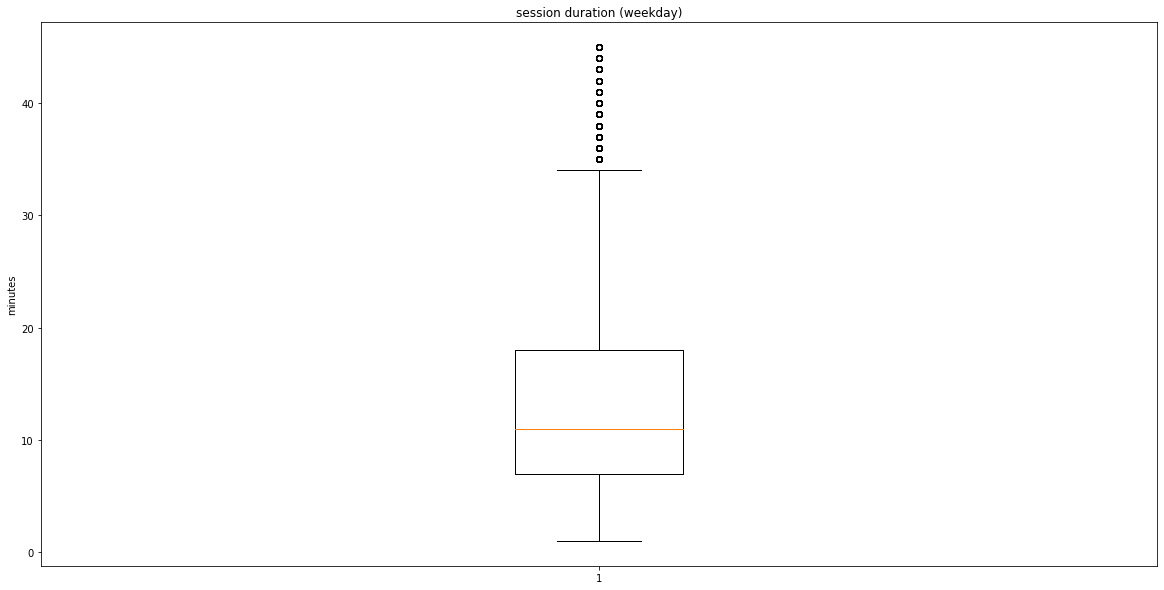

In [23]:
plt.boxplot(df_weekday['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekday)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_box_weekday.png')
plt.show()

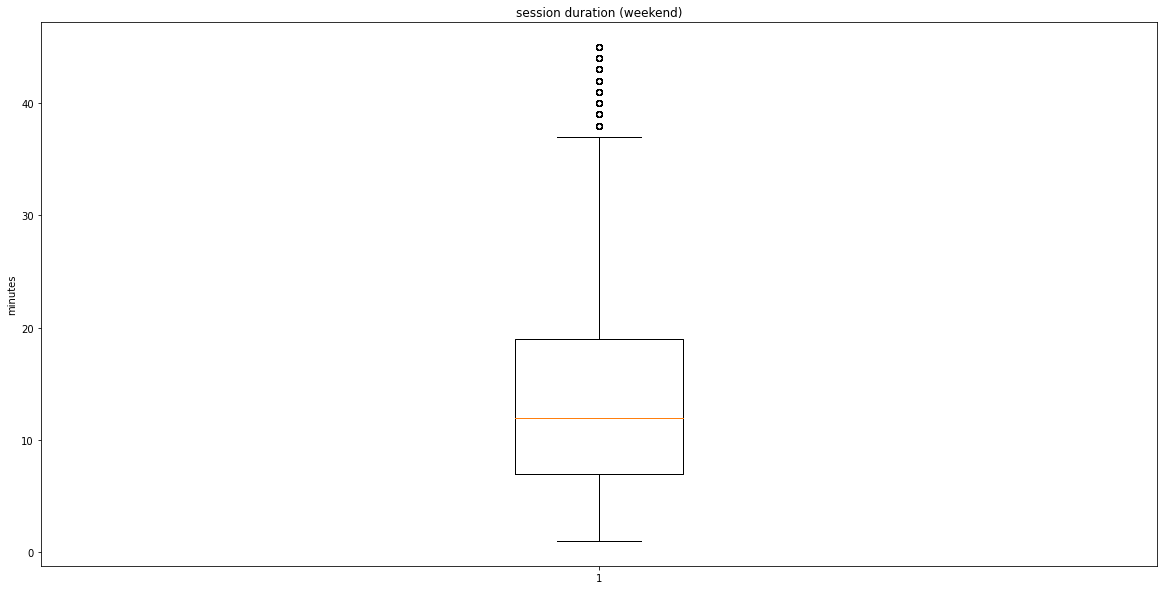

In [24]:
plt.boxplot(df_weekend['Session_Duration'])
# plt.rcParams["figure.figsize"] = (10,5)
plt.ylabel("minutes")
plt.title("session duration (weekend)") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_box_weekend.png')
plt.show()

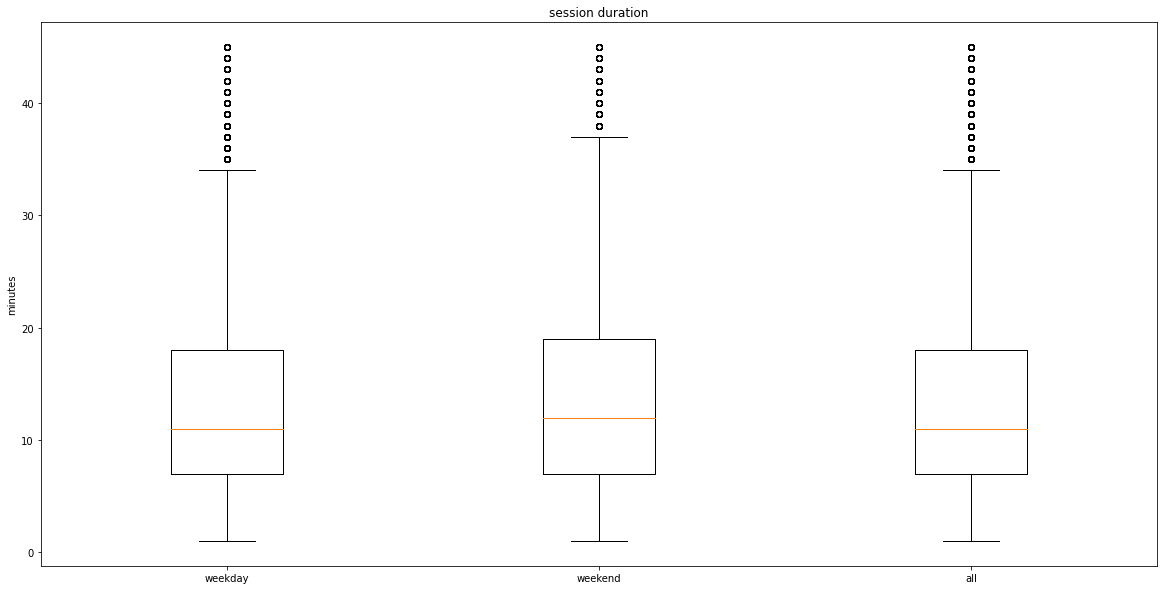

In [26]:
value_dict = {'weekday': df_weekday['Session_Duration'], 'weekend': df_weekend['Session_Duration'], 'all': dfpk['Session_Duration']}

fig, ax = plt.subplots()
ax.boxplot(value_dict.values())
ax.set_xticklabels(value_dict.keys())
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel("minutes")
plt.title("session duration") 
plt.savefig('/home/doktormatte/Dropbox/Dokumente/Studium/MA_SciComp/Data/Plots/Pre_covid/perth_kinross_boxes.png')
plt.show()